# FC autoencoder

### data load

In [226]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [227]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [228]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### build autoencoder

In [36]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

input_shape = 784
encoding_dim = 32

In [17]:
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu')(input_img)


from keras import regularizers
encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)

decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# regularize : more reduce encoding_dim

from keras import regularizers  
encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)  


# more deep

input_img = Input(shape=(784,))  
encoded = Dense(128, activation='relu')(input_img)  
encoded = Dense(64, activation='relu')(encoded)  
encoded = Dense(32, activation='relu')(encoded)  
  
decoded = Dense(64, activation='relu')(encoded)  
decoded = Dense(128, activation='relu')(decoded)  
decoded = Dense(784, activation='sigmoid')(decoded)  

In [18]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_6 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [253]:
es_cb = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1, mode='auto')

In [20]:

autoencoder.fit(x_train, x_train,epochs=100, batch_size=256,shuffle=True,
                validation_data=(x_test, x_test), callbacks=[es_cb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2748 - val_loss: 0.1879
Epoch 2/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1704 - val_loss: 0.1533
Epoch 3/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1440 - val_loss: 0.1333
Epoch 4/100
60000/60000 [==============================] - 2s 36us/step - loss: 0.1281 - val_loss: 0.1209
Epoch 5/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1181 - val_loss: 0.1130
Epoch 6/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1114 - val_loss: 0.1073
Epoch 7/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1065 - val_loss: 0.1033
Epoch 8/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.1029 - val_loss: 0.1000
Epoch 9/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.1001 - val_loss: 0.0

In [21]:
autoencoder.save_weights('autoencoder.h5')

### another notation (add)

In [25]:
def make_FCae(encoding_dim,input_shape):
    model = Sequential()
    model.add(Dense(encoding_dim, activation='relu',input_shape=(input_shape,)))
    model.add(Dense(input_shape,activation='sigmoid'))
    return model

In [ ]:
ae = make_FCae(encoding_dim,input_shape)
ae.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
ae.summary()

In [ ]:
ae.fit(x_train, x_train,epochs=5,batch_size=256,shuffle=True,
       validation_data=(x_test, x_test))

In [ ]:
ae.save_weights('autoencoder.h5')

# test image encode to latent value

In [29]:
def make_encoder():
    encoder= make_FCae(encoding_dim, input_shape)
    encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    encoder.load_weights('autoencoder.h5')
    
    encoder_model = Model(inputs=encoder.layers[0].input, outputs=encoder.layers[0].output)
    
    encoder_model.trainable = False
    
    encoder_model.compile(loss='binary_crossentropy', optimizer='adam')
    return encoder_model

In [30]:
encoder_model = make_encoder()

In [31]:
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 0
Non-trainable params: 25,120
_________________________________________________________________


In [ ]:
latent_value = encoder_model.predict(x_test[:10])

# reconstruct images

In [33]:
autoencoder= make_FCae(encoding_dim, input_shape)
autoencoder.load_weights('autoencoder.h5')
autoencoder.trainable = False
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [34]:
pred_img = autoencoder.predict(x_test[:10])

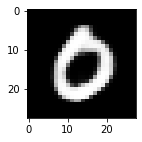

In [38]:
plt.figure(figsize=(2, 2))
plt.imshow(pred_img[3].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

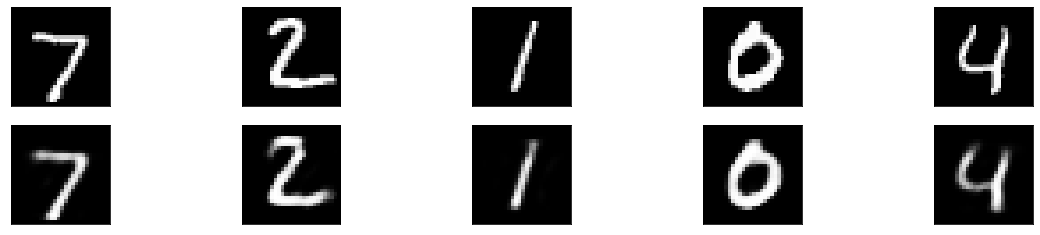

In [40]:

n = 5
plt.figure(figsize=(20, 4))

for i in range(n):
    
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pred_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# anomaly detection use Autoencoder

In [44]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [45]:
x_train_1 = x_train[y_train == 1]

x_test_1 = x_test[y_test == 1]
x_test_9 = x_test[y_test == 9]

In [46]:
x_train_1 = x_train_1.astype('float32') / 255.
x_test_1 = x_test_1.astype('float32') / 255.
x_test_9 = x_test_9.astype('float32') / 255.

In [47]:
x_train_1 = x_train_1.reshape((len(x_train_1), np.prod(x_train_1.shape[1:])))
x_test_1 = x_test_1.reshape((len(x_test_1), np.prod(x_test_1.shape[1:])))
x_test_9 = x_test_9.reshape((len(x_test_9), np.prod(x_test_9.shape[1:])))

In [48]:
ae = make_FCae(encoding_dim,input_shape)
ae.compile(optimizer='adam', loss='binary_crossentropy')

In [49]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_12 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [51]:
ae.fit(x_train_1, x_train_1,epochs=100, batch_size=256,shuffle=True,
       validation_data=(x_test_1, x_test_1), callbacks=[es_cb])

Train on 6742 samples, validate on 1135 samples
Epoch 1/100
6742/6742 [==============================] - 0s 32us/step - loss: 0.0880 - val_loss: 0.0836
Epoch 2/100
6742/6742 [==============================] - 0s 29us/step - loss: 0.0830 - val_loss: 0.0799
Epoch 3/100
6742/6742 [==============================] - 0s 30us/step - loss: 0.0802 - val_loss: 0.0778
Epoch 4/100
6742/6742 [==============================] - 0s 30us/step - loss: 0.0783 - val_loss: 0.0761
Epoch 5/100
6742/6742 [==============================] - 0s 30us/step - loss: 0.0765 - val_loss: 0.0740
Epoch 6/100
6742/6742 [==============================] - 0s 31us/step - loss: 0.0743 - val_loss: 0.0717
Epoch 7/100
6742/6742 [==============================] - 0s 30us/step - loss: 0.0721 - val_loss: 0.0694
Epoch 8/100
6742/6742 [==============================] - 0s 29us/step - loss: 0.0698 - val_loss: 0.0671
Epoch 9/100
6742/6742 [==============================] - 0s 30us/step - loss: 0.0676 - val_loss: 0.0651
Epoch 10/100
674

In [52]:
ae.save_weights('autoencoder_anomaly_detect.h5')

In [53]:
autoencoder_detect= make_FCae(encoding_dim, input_shape)
autoencoder_detect.load_weights('autoencoder_anomaly_detect.h5')
autoencoder_detect.trainable = False
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [104]:
check_number = 30

pred_img_1 = autoencoder_detect.predict(x_test_1[:30])
pred_img_9 = autoencoder_detect.predict(x_test_9[:30])

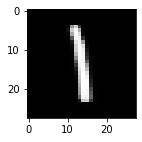

In [105]:
plt.figure(figsize=(2, 2))
plt.imshow(pred_img_1[3].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

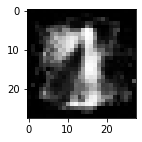

In [106]:
plt.figure(figsize=(2, 2))
plt.imshow(pred_img_9[3].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

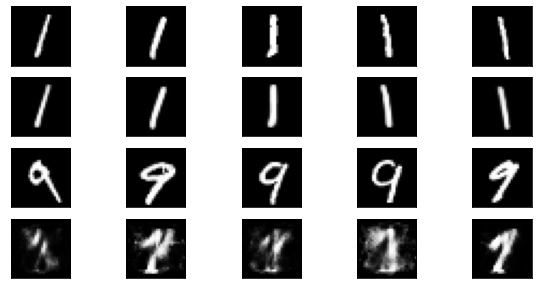

In [107]:

n=5

plt.figure(figsize=(10, 5))

for i in range(n):
    
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(pred_img_1[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(x_test_9[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(pred_img_9[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
plt.show()

In [108]:
sum(abs(x_test_1[0] - pred_img_1[0]))

6.617225123569369

In [109]:
sum(abs(x_test_9[0] - pred_img_9[0]))

76.82280905917287

In [151]:
score_normal=[]
score_abnormal=[]

for i in range(check_number):
    score_normal.append(sum(abs(x_test_1[i] - pred_img_1[i])))
    score_abnormal.append(sum(abs(x_test_1[i] - pred_img_9[i])))

In [152]:
score_normal.extend(score_abnormal)

In [153]:
label = np.zeros(check_number*2)
label[check_number:] = 1

In [154]:
score_index = list(range(0, check_number*2, 1))

In [165]:
import pandas as pd
import seaborn as sns

In [163]:
df = pd.DataFrame()

In [164]:
df["score"] = score_normal
df["number"] = score_index
df["label"] = label

<AxesSubplot:xlabel='number', ylabel='score'>

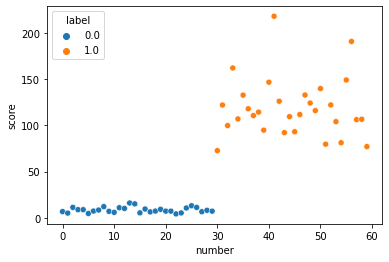

In [167]:
sns.scatterplot(data=df, x="number", y="score", hue="label")

In [175]:
#そもそもの空白の空間が多い画像ほど、一致度も高くなる。
#全部のタスクでうまくいくわけではない

# KDE for latent space

In [181]:

def make_normal_encoder():
    encoder= make_FCae(encoding_dim, input_shape)
    encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    encoder.load_weights('autoencoder_anomaly_detect.h5')
    
    encoder_model = Model(inputs=encoder.layers[0].input, outputs=encoder.layers[0].output)
    
    encoder_model.trainable = False
    
    encoder_model.compile(loss='binary_crossentropy', optimizer='adam')
    return encoder_model


In [182]:
encoder_model = make_normal_encoder()

encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17_input (InputLayer)  (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                25120     
Total params: 25,120
Trainable params: 0
Non-trainable params: 25,120
_________________________________________________________________


In [183]:
x_train_1_latent_value = encoder_model.predict(x_train_1[:100])

x_test_1_latent_value = encoder_model.predict(x_test_1[:100])

x_test_9_latent_value = encoder_model.predict(x_test_9[:100])

In [184]:
x_train_1_latent_value_flat = [np.reshape(img, (32)) for img in x_train_1_latent_value]

x_test_1_latent_value_flat = [np.reshape(img, (32)) for img in x_test_1_latent_value]

x_test_9_latent_value_flat = [np.reshape(img, (32)) for img in x_test_9_latent_value]

In [ ]:
from sklearn.neighbors import KernelDensity

In [185]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(latent_value_flat)

x_train_1_density_scores = kde.score_samples(x_train_1_latent_value_flat)

x_test_1_density_scores = kde.score_samples(x_test_1_latent_value_flat)

x_test_9_density_scores = kde.score_samples(x_test_9_latent_value_flat)

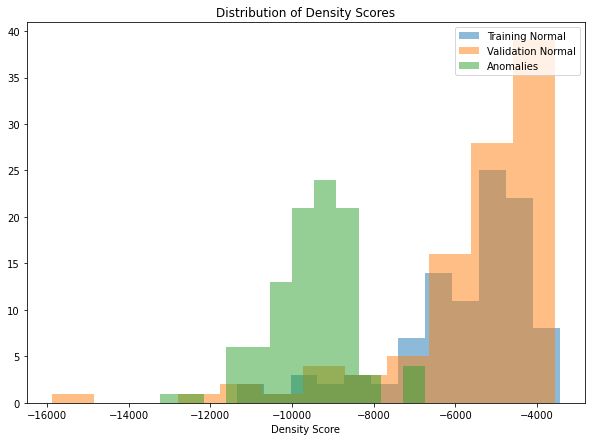

In [186]:
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(x_train_1_density_scores, 12, alpha=0.5, label='Training Normal')
plt.hist(x_test_1_density_scores, 12, alpha=0.5, label='Validation Normal')
plt.hist(x_test_9_density_scores, 12, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

In [192]:
from sklearn.manifold import TSNE

In [196]:
x_test_1_embedded = TSNE(n_components=2).fit_transform(x_test_1_latent_value)
x_test_9_embedded = TSNE(n_components=2).fit_transform(x_test_9_latent_value)
x_train_1_embedded = TSNE(n_components=2).fit_transform(x_train_1_latent_value)

In [220]:
normal_test_enbedded_space = pd.DataFrame()

normal_test_enbedded_space["X"] = x_test_1_embedded[:,0]
normal_test_enbedded_space["Y"] = x_test_1_embedded[:,1]
normal_test_enbedded_space["label"] = "test" # normal test

In [221]:
abnormal_test_enbedded_space = pd.DataFrame()

abnormal_test_enbedded_space["X"] = x_test_9_embedded[:,0]
abnormal_test_enbedded_space["Y"] = x_test_9_embedded[:,1]
abnormal_test_enbedded_space["label"] = "abnormal" # abnormal test

In [222]:
train_enbedded_space = pd.DataFrame()

train_enbedded_space["X"] = x_train_1_embedded[:,0]
train_enbedded_space["Y"] = x_train_1_embedded[:,1]
train_enbedded_space["label"] = "train" # normal train

In [224]:
enbedded_space = pd.concat([train_enbedded_space, 
                            normal_test_enbedded_space, 
                            abnormal_test_enbedded_space],axis=0)

<AxesSubplot:xlabel='X', ylabel='Y'>

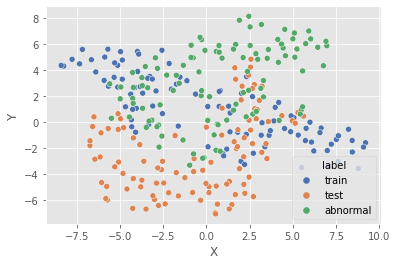

In [225]:
sns.scatterplot(data=enbedded_space, x="X", y="Y", hue="label", palette="deep")

# conv autoencoder

In [229]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [232]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0         
__________

In [233]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) 
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 

In [234]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 66s 1ms/step - loss: 0.2140 - val_loss: 0.1618
Epoch 2/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1538 - val_loss: 0.1475
Epoch 3/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1394 - val_loss: 0.1342
Epoch 4/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1329 - val_loss: 0.1283
Epoch 5/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1285 - val_loss: 0.1246
Epoch 6/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1251 - val_loss: 0.1255
Epoch 7/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1229 - val_loss: 0.1250
Epoch 8/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.1211 - val_loss: 0.1181
Epoch 9/10
60000/60000 [==============================] - 65s 1ms/step - loss: 0.1199 - val_loss: 0.1161
Epoch

In [237]:
decoded_imgs = autoencoder.predict(x_test)

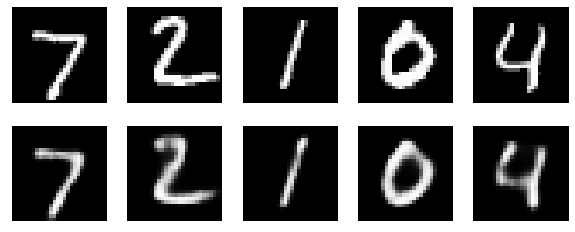

In [242]:
n = 5

plt.figure(figsize=(10, 4))

for i in range(n):

    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i +1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# denoising autoencoder

In [243]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

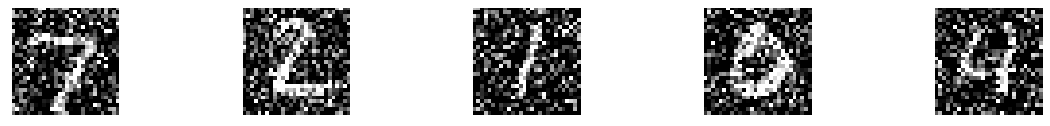

In [246]:
n = 5
plt.figure(figsize=(20, 2))

for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [247]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [249]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 32)        0         
__________

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', 
                                       histogram_freq=0, 
                                       write_graph=False)])

In [254]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[es_cb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 121s 2ms/step - loss: 0.0959 - val_loss: 0.0962
Epoch 2/100
60000/60000 [==============================] - 133s 2ms/step - loss: 0.0959 - val_loss: 0.0953
Epoch 3/100
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0958 - val_loss: 0.0951
Epoch 4/100
60000/60000 [==============================] - 131s 2ms/step - loss: 0.0957 - val_loss: 0.0950
Epoch 5/100
60000/60000 [==============================] - 129s 2ms/step - loss: 0.0957 - val_loss: 0.0953
Epoch 6/100
60000/60000 [==============================] - 139s 2ms/step - loss: 0.0957 - val_loss: 0.0954
Epoch 00006: early stopping


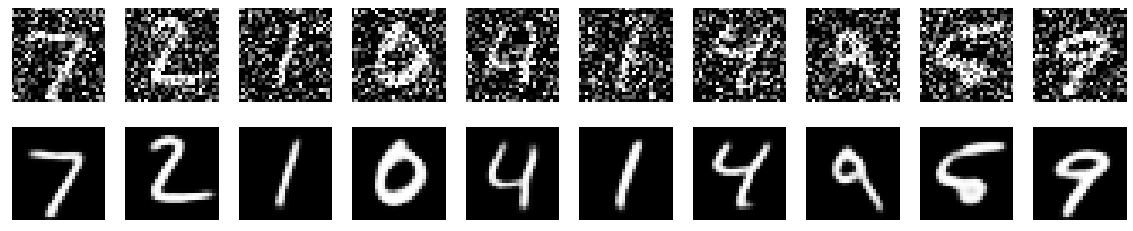

In [252]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()